# Tarea de imputación de valores perdidos

## Importamos las librerías necesarias

In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn import linear_model, metrics
from scipy.spatial.distance import cdist, squareform
import math

## Cargamos y visualizamos los datos

Podemos observar que, salvo la columna 'quality', todas las variables tienen valores perdidos.

Guardaremos el conjunto global de posiciones perdidas por columna para usarlo más tarde.

In [244]:
true_wine_df = pd.read_csv('wine/winequality-white.csv', sep=';', dtype={'quality': 'object'})
wine_df = pd.read_csv('wine/winequality-white-missing.csv', sep=';', dtype={'quality': 'object'})
wine_df.info()

lost_positions = wine_df[:].isnull()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4400 non-null   float64
 1   volatile acidity      4431 non-null   float64
 2   citric acid           4411 non-null   float64
 3   residual sugar        4434 non-null   float64
 4   chlorides             4387 non-null   float64
 5   free sulfur dioxide   4398 non-null   float64
 6   total sulfur dioxide  4429 non-null   float64
 7   density               4413 non-null   float64
 8   pH                    4415 non-null   float64
 9   sulphates             4372 non-null   float64
 10  alcohol               4412 non-null   float64
 11  quality               4898 non-null   object 
dtypes: float64(11), object(1)
memory usage: 459.3+ KB


## Imputación múltiple por ecuaciones encadenadas

In [245]:
def MICE(dataframe, iterations=100):
    """Realiza el método de imputación múltiple por ecuaciones encadenadas
    
        :param dataframe: Dataframe de Pandas con en dataset a tratar
        :param iterations: Número de iteraciones que se usarán en el método
        :type dataframe: <class 'pandas.core.frame.DataFrame'>
        :type iterations: int
        :return: Retorna una copia del dataframe en el que se recuperaron los valores perdidos
        :rtype: <class 'pandas.core.frame.DataFrame'>

    """
    df = dataframe.copy()
    
    # Imputación simple a todas las variables con valores perdidos
    loss_pos = df[:].isnull()
    df.fillna(df.mean(), inplace=True)
    
    
    for _ in range(iterations):
        for xi in df.columns:
            # Cambiamos los valores imputados para xi anteriormente y lo 'perdemos' 
            xi_mean = df.copy()[xi]
            df.loc[loss_pos[xi], xi] = None
            
            # Realizamos regresión usando la media de xi y las medias del resto de columnas
            l_model = linear_model.LinearRegression()
            vr = xi_mean
            vp = df.loc[:, df.columns != xi]
            l_model.fit(vp, vr)
            
            # Realizamos la predicción para los valores perdidos de la columna xi y procedemos a sustituir los valores perdidos
            predict = l_model.predict(vp.loc[loss_pos[xi]])
            df.loc[loss_pos[xi], xi] = predict 
        
    return df
    

### Ejecución y cálculo del error de la función

Tras la ejecución del método MICE, podemos verificar que ya no existen valores nulos para nuestro conjunto de datos.

In [246]:
mice_df = MICE(wine_df.iloc[:, 0:11])
mice_df.info()
mice_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
dtypes: float64(11)
memory usage: 421.0 KB


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.849376,0.277632,0.334760,6.396539,0.045914,35.338499,138.065889,0.994027,3.188215,0.489780,10.514622
std,0.819329,0.096033,0.116968,5.037226,0.021448,16.981656,41.297176,0.002991,0.147836,0.108802,1.221027
min,3.800000,0.043670,0.000000,-1.010269,0.009000,-185.065124,9.000000,0.986933,2.740000,0.220000,5.753723
25%,6.300000,0.220000,0.270000,1.800000,0.036000,24.000000,109.000000,0.991740,3.090000,0.420000,9.500000
50%,6.800000,0.265000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993770,3.180000,0.480000,10.400000
75%,7.300000,0.320000,0.380000,9.850000,0.050000,45.024962,166.000000,0.996100,3.274035,0.540000,11.400000
max,11.800000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000


Procedemos a realizar el error cuadrático medio del dataset obtenido con el método MICE frente al dataset original, sin valores perdidos.

El resultado nos indica unos resultados bastante aceptables a excepción de las columnas 'free sulfur dioxide' y 'total sulfur dioxide'

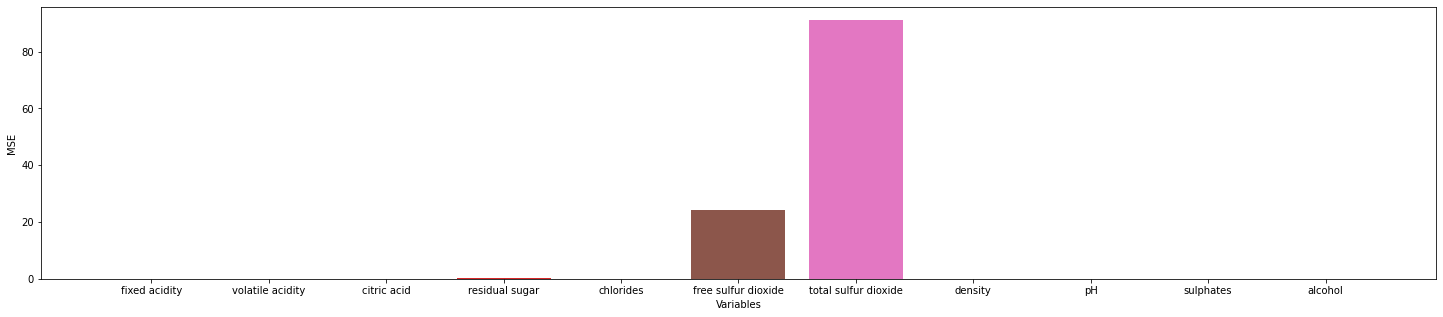

In [247]:
columns = true_wine_df.iloc[:, 0:11].columns

plt.figure(figsize=(25, 5))

for column in columns:
    mse = metrics.mean_squared_error(mice_df[column], true_wine_df[column])
    errors[column] = mse
    plt.bar(column, mse)  

plt.xlabel("Variables")
plt.ylabel("MSE")
plt.show()

## Imputación Hot-Deck por muestra más próxima

In [248]:
def hot_deck(dataframe):
    """Realiza el método hot deck por muestra más próxima
    
        :param dataframe: Dataframe de Pandas con en dataset a tratar
        :type dataframe: <class 'pandas.core.frame.DataFrame'>
        :return: Retorna una copia del dataframe en el que se recuperaron los valores perdidos
        :rtype: <class 'pandas.core.frame.DataFrame'>

    """
    df = dataframe.copy()
    
    loss_pos = df.isnull().any(axis=1)
    
    for i in df[loss_pos].index:
        # Para fila 'i', buscamos sus columnas con nan y filtramos el resto de valores
        # para que tengan valor en dichas columnas
        loss_col_i = df[loss_pos].loc[i].isnull()
        
        all_rows = df[~loss_pos].loc[:, ~loss_col_i]
        
        # Calculamos la distancia entre la fila 'i' y todas las filas que no tienen nan
        d1 = df.loc[i, ~loss_col_i]
        d2 = all_rows
        
        d = ((d1-d2)**2).sum(axis=1)
        d = np.sqrt(d)
        
        # Asignamos los valores de las columnas perdidas a la fila 'i' usando los datos de la fila con menor distancia 
        min_row = d.idxmin()
        
        nearest_row = df.loc[min_row, loss_col_i]
        df.loc[i, loss_col_i] = nearest_row

    return df

In [249]:
hot_deck_df = hot_deck(wine_df.iloc[:, 0:11])
hot_deck_df.info()
hot_deck_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
dtypes: float64(11)
memory usage: 421.0 KB


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.851317,0.277708,0.334390,6.398111,0.045815,35.477338,137.947530,0.994022,3.188940,0.490433,10.517588
std,0.839657,0.100698,0.122218,5.087587,0.021970,17.168676,41.902646,0.002994,0.152225,0.114651,1.231918
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.740000,0.220000,8.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991740,3.082500,0.410000,9.500000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993700,3.180000,0.475000,10.400000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000
max,11.800000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000


Procedemos a realizar el error cuadrático medio del dataset obtenido con el método Hot deck frente al dataset original, sin valores perdidos.

El resultado nos indica unos resultados bastante aceptables a excepción de las columnas 'free sulfur dioxide' y 'total sulfur dioxide', como en el método MICE.

Sin embargo, podemos apreciar que el error es mayor, cerca del doble, que con el algoritmo anterior.

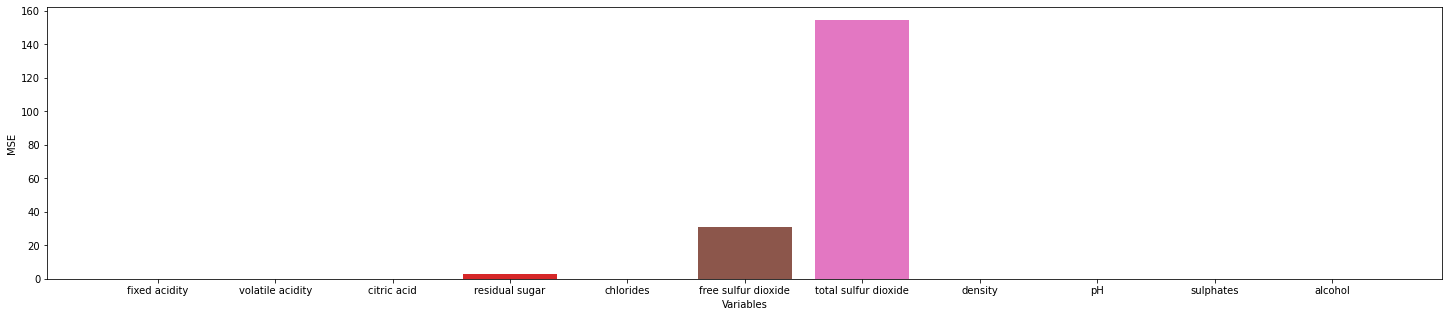

In [250]:
columns = true_wine_df.iloc[:, 0:11].columns

plt.figure(figsize=(25, 5))

for column in columns:
    mse = metrics.mean_squared_error(hot_deck_df[column], true_wine_df[column])
    errors[column] = mse
    plt.bar(column, mse)

plt.xlabel("Variables")
plt.ylabel("MSE")
plt.show()

## Conclusión

Con los resultados obtenidos, podemos decir que para este dataset, el método resulta más efectivo, debido a su menor error. 

Además, el método MICE con 100 iteraciones resulta también más rápido que el Hot deck.